# Modelo de Diagnóstico de Diabetes

Esse notebook apresenta uma implementação de um modelo de Machine Learning supervisionado de classificação binária para a previsão de diagnóstico de diabetes a partir de um obtuário médico de um paciente. O dataset utilizado neste modelo foi obtido através do [Kaggle](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


## Dicionário de Dados
O dataset possui 100 mil linhas e 9 colunas. Abaixo estão as descrições de cada coluna:

1. **gender:** Identidade de gênero do paciente;
2. **age:** Idade do paciente (em anos);
3. **hypertension:** Diagnóstico para hipertensão (0 para Negativo e 1 para Positivo);
4. **heart_disease:** Diagnóstico para doenças cardíacas (0 para Negativo e 1 para Positivo);
5. **smoking_history:** Histórico de tabagismo;
6. **bmi:** Índice de Massa Corporal (IMC);
7. **HbA1c_level:** Nível de Hemoglobina A1C;
8. **blood_glucose_level:** Nível de glicose sanguínea;
9. **diabetes:** Nossa variável target, diagnóstico de * (0 para Negativo e 1 para Positivo);

A partir dos dados das colunas 1 até 8 de obtuários de pacientes e dos diagnósticos da coluna 9, vamos implementar um modelo supervisionado de classificação binária para previsão de diagnóstico de diabetes.

## Tratamento de Dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [4]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [5]:
duplicated = df.duplicated().sum()
percentage = round(duplicated / df.shape[0] * 100, 2)

print(f'Temos {duplicated} linhas duplicadas, representando {percentage}% do nosso dataset')

Temos 3854 linhas duplicadas, representando 3.85% do nosso dataset


In [6]:
df.drop_duplicates(inplace=True)
df.shape

(96146, 9)

In [7]:
df.age = df.age.astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96146 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96146 non-null  object 
 1   age                  96146 non-null  int64  
 2   hypertension         96146 non-null  int64  
 3   heart_disease        96146 non-null  int64  
 4   smoking_history      96146 non-null  object 
 5   bmi                  96146 non-null  float64
 6   HbA1c_level          96146 non-null  float64
 7   blood_glucose_level  96146 non-null  int64  
 8   diabetes             96146 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 7.3+ MB


## Análise Exploratória de Dados

In [8]:
df.diabetes.value_counts()

0    87664
1     8482
Name: diabetes, dtype: int64

In [9]:
df.diabetes.value_counts(normalize=True) * 100

0    91.178
1     8.822
Name: diabetes, dtype: float64

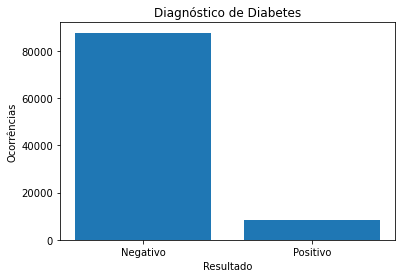

In [10]:
target = df.diabetes.value_counts()

plt.bar(target.index, target.values)
plt.title('Diagnóstico de Diabetes')
plt.xlabel('Resultado')
plt.ylabel('Ocorrências')
plt.xticks([0, 1], ['Negativo', 'Positivo'])
plt.show()

In [11]:
df.gender.value_counts()

Female    56161
Male      39967
Other        18
Name: gender, dtype: int64

In [12]:
df.gender.value_counts(normalize=True) * 100

Female    58.412206
Male      41.569072
Other      0.018722
Name: gender, dtype: float64

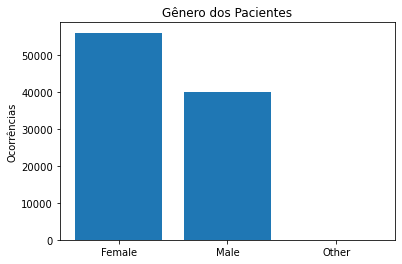

In [13]:
data = df.gender.value_counts()

plt.bar(data.index, data.values)
plt.title('Gênero dos Pacientes')
plt.ylabel('Ocorrências')
plt.show()

In [14]:
df.age.describe()

count    96146.000000
mean        41.783756
std         22.482208
min          0.000000
25%         24.000000
50%         43.000000
75%         59.000000
max         80.000000
Name: age, dtype: float64

<AxesSubplot:ylabel='Frequency'>

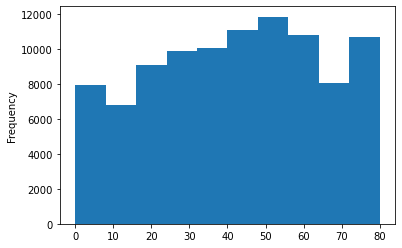

In [15]:
df.age.plot(kind='hist')

<AxesSubplot:>

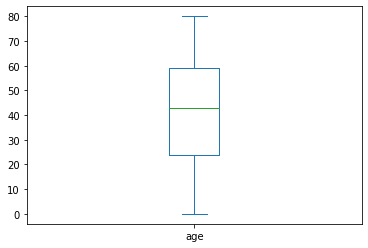

In [16]:
df.age.plot(kind='box')

In [17]:
df.hypertension.value_counts()

0    88685
1     7461
Name: hypertension, dtype: int64

In [18]:
df.hypertension.value_counts(normalize=True) * 100

0    92.239927
1     7.760073
Name: hypertension, dtype: float64

In [19]:
df.heart_disease.value_counts()

0    92223
1     3923
Name: heart_disease, dtype: int64

In [20]:
df.heart_disease.value_counts(normalize=True) * 100

0    95.919747
1     4.080253
Name: heart_disease, dtype: float64

In [21]:
df.smoking_history.value_counts()

never          34398
No Info        32887
former          9299
current         9197
not current     6367
ever            3998
Name: smoking_history, dtype: int64

In [22]:
df.smoking_history.value_counts(normalize=True) * 100

never          35.776839
No Info        34.205271
former          9.671749
current         9.565661
not current     6.622220
ever            4.158259
Name: smoking_history, dtype: float64

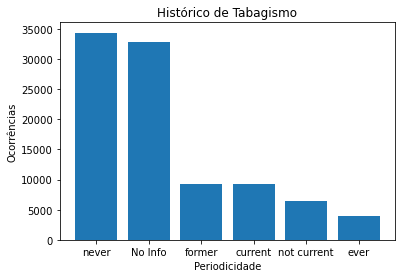

In [23]:
data = df.smoking_history.value_counts()

plt.bar(data.index, data.values)
plt.title('Histórico de Tabagismo')
plt.xlabel('Periodicidade')
plt.ylabel('Ocorrências')
plt.show()

In [24]:
df.bmi.describe()

count    96146.000000
mean        27.321461
std          6.767716
min         10.010000
25%         23.400000
50%         27.320000
75%         29.860000
max         95.690000
Name: bmi, dtype: float64

<AxesSubplot:ylabel='Frequency'>

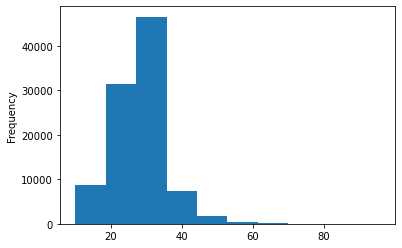

In [25]:
df.bmi.plot(kind='hist')

<AxesSubplot:>

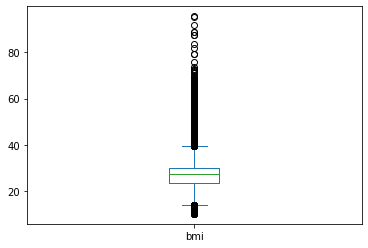

In [26]:
df.bmi.plot(kind='box')

In [27]:
df.HbA1c_level.describe()

count    96146.000000
mean         5.532609
std          1.073232
min          3.500000
25%          4.800000
50%          5.800000
75%          6.200000
max          9.000000
Name: HbA1c_level, dtype: float64

<AxesSubplot:ylabel='Frequency'>

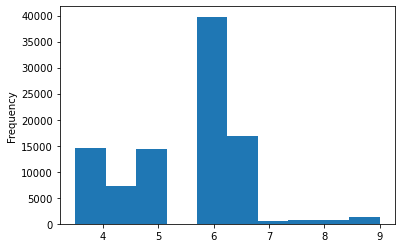

In [28]:
df.HbA1c_level.plot(kind='hist')

<AxesSubplot:>

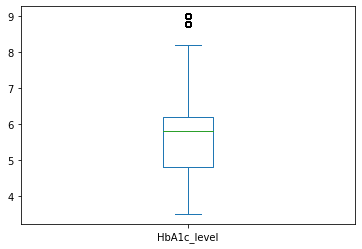

In [29]:
df.HbA1c_level.plot(kind='box')

In [30]:
df.blood_glucose_level.describe()

count    96146.000000
mean       138.218231
std         40.909771
min         80.000000
25%        100.000000
50%        140.000000
75%        159.000000
max        300.000000
Name: blood_glucose_level, dtype: float64

<AxesSubplot:ylabel='Frequency'>

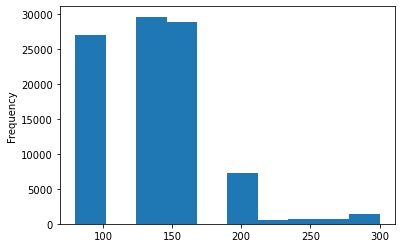

In [31]:
df.blood_glucose_level.plot(kind='hist')

<AxesSubplot:>

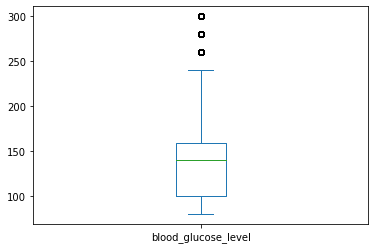

In [32]:
df.blood_glucose_level.plot(kind='box')

<AxesSubplot:>

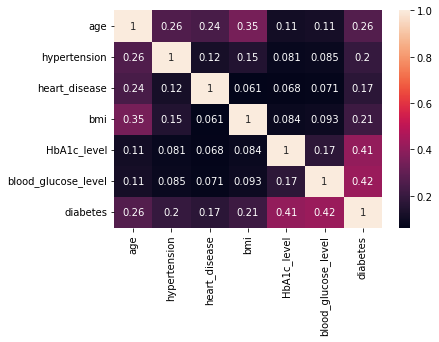

In [33]:
sns.heatmap(data=df.corr(), annot=True)

## Pré-Processamento de Dados

In [34]:
df.drop(columns=['smoking_history'], inplace=True)

In [35]:
df.drop(df[df.gender == 'Other'].index, inplace=True)
df.gender.value_counts()

Female    56161
Male      39967
Name: gender, dtype: int64

In [36]:
le = LabelEncoder()
df.gender = le.fit_transform(df.gender)

In [37]:
x = df.drop('diabetes', axis=1)
x

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level
0,0,80,0,1,25.19,6.6,140
1,0,54,0,0,27.32,6.6,80
2,1,28,0,0,27.32,5.7,158
3,0,36,0,0,23.45,5.0,155
4,1,76,1,1,20.14,4.8,155
...,...,...,...,...,...,...,...
99994,0,36,0,0,24.60,4.8,145
99996,0,2,0,0,17.37,6.5,100
99997,1,66,0,0,27.83,5.7,155
99998,0,24,0,0,35.42,4.0,100


In [38]:
y = df.diabetes
y

0        0
1        0
2        0
3        0
4        0
        ..
99994    0
99996    0
99997    0
99998    0
99999    0
Name: diabetes, Length: 96128, dtype: int64

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

## Implementando o Modelo Supervisionado

### Regressão Logística

In [40]:
model = LogisticRegression()
model.fit(x_train, y_train)

/home/edison/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     26222
           1       0.87      0.64      0.74      2617

    accuracy                           0.96     28839
   macro avg       0.92      0.81      0.86     28839
weighted avg       0.96      0.96      0.96     28839



<AxesSubplot:>

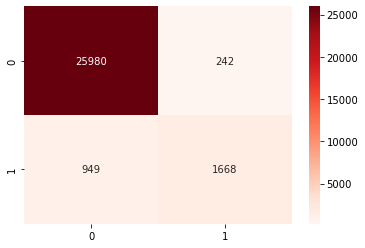

In [42]:
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Reds")

### Random Forest

In [43]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [44]:
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     26222
           1       0.92      0.70      0.80      2617

    accuracy                           0.97     28839
   macro avg       0.95      0.85      0.89     28839
weighted avg       0.97      0.97      0.97     28839



<AxesSubplot:>

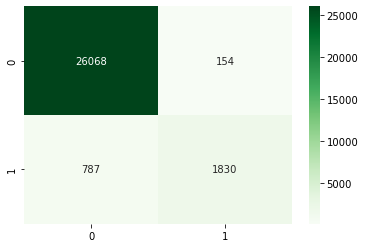

In [45]:
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Greens")

### XGBoost

In [46]:
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [47]:
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     26222
           1       0.97      0.70      0.81      2617

    accuracy                           0.97     28839
   macro avg       0.97      0.85      0.90     28839
weighted avg       0.97      0.97      0.97     28839



<AxesSubplot:>

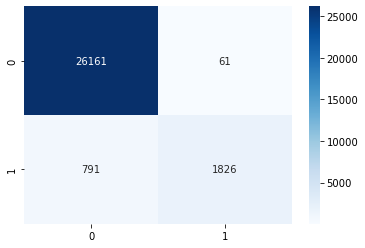

In [48]:
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")